In [1]:
from lstchain.io.io import dl2_params_lstcam_key
from ctapipe.io import read_table
import matplotlib.pyplot as plt
import numpy as np
import ctaplot
import astropy.units as u
from astropy.visualization import quantity_support
from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")

ctaplot.set_style('notebook')

In [2]:
# Reading DL2 parameters

filename = 'dl2_gamma-diffuse_20deg_180deg_20220215_v0.9.1_prod5_trans_80_local_tailcut_8_4_testing.h5'
params = read_table(filename, path=dl2_params_lstcam_key)

In [3]:
params[:4]

<Table length=4>
obs_id event_id     intensity        log_intensity             x           ...      reco_alt           reco_az       reco_type     gammaness     
int32   int64        float64            float64             float64        ...      float64            float64         int64        float64      
------ -------- ------------------ ------------------ -------------------- ... ------------------ ------------------ --------- ------------------
  1001      709 204.69166946411133  2.311100168117379  -0.9429552882748465 ... 1.1729915791160523 3.1562981500860525       101 0.4760000000000001
  1001    14702  217.4642243385315  2.337387820139739  0.46072834092859943 ... 1.2317426248864978   3.20911681028575       101 0.3741666666666666
  1001    15008 165.50613975524902  2.218814109364702  -0.9169175343015934 ... 1.1881988117550633  3.123140245988693       101             0.0455
  1001    24006  5026.379844665527 3.7012553052292714 -0.46367241536546555 ...  1.221787863315046  3.130670740376984         0               0.96

In [4]:
def add_params(events):
    """
    add some parameters and units
    """
    for pos in ['reco_src_x', 'reco_src_y', 'src_x', 'src_y', 'reco_disp_dx', 'reco_disp_dy', 'x', 'y']:
        events[pos].unit = u.m
    
    for ang in ['reco_alt', 'reco_az', 'mc_alt', 'mc_az', 'alt_tel', 'az_tel']:
        events[ang].unit = u.rad
        
    for ene in ['reco_energy', 'mc_energy']:
        events[ene].unit = u.TeV
    
    events['diff_x'] = events['reco_src_x'] - events['src_x']
    events['diff_y'] = events['reco_src_y'] - events['src_y']
    events['diff_alt'] = events['reco_alt'] - events['mc_alt']
    events['diff_az'] = events['reco_az'] - events['mc_az']
    events['diff'] = np.sqrt(events['diff_x']**2 + events['diff_y']**2)
    events['offset'] = ctaplot.ana.ana.angular_separation_altaz(events['alt_tel'].quantity, events['az_tel'].quantity,
                                                                events['mc_alt'].quantity, events['mc_az'].quantity)
    events['alpha'] = np.arctan2(events['src_y'], events['src_x'])

In [5]:
add_params(params)

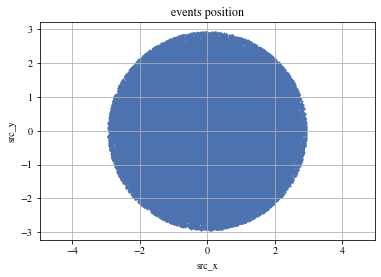

In [6]:
def plot_true_pos(events, ax=None):
    ax = plt.gca() if ax is None else ax
    ax.scatter(events['src_x'], events['src_y'], s=1);
    ax.grid(True)
    ax.axis('equal')
    ax.set_xlabel('src_x')
    ax.set_ylabel('src_y')
    ax.set_title('events position')
    return ax

plot_true_pos(params);

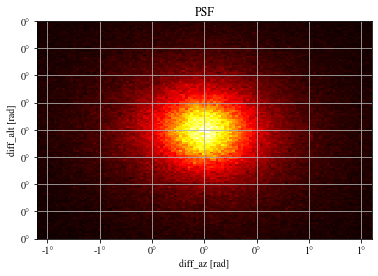

In [7]:
def plot_psf(events, ax=None):
    ax = plt.gca() if ax is None else ax
    rx = 1.6
    ry = 0.4
    # ax.hist2d(events['diff_x'], events['diff_y'], bins=100, range=[[-r,r],[-r,r]]);
    diff_az = events['reco_az'] - events['mc_az']
    diff_alt = events['reco_alt'] - events['mc_alt']
    with quantity_support():
        ax.hist2d(diff_az.to(u.deg), diff_alt.to(u.deg), 
              bins=120, range=[[-rx,rx],[-ry,ry]], cmap='hot')
    ax.grid(True)
    # ax.axis('equal')
    ax.set_xlabel('diff_az [rad]')
    ax.set_ylabel('diff_alt [rad]')
    ax.set_title('PSF')
    return ax

plot_psf(params);


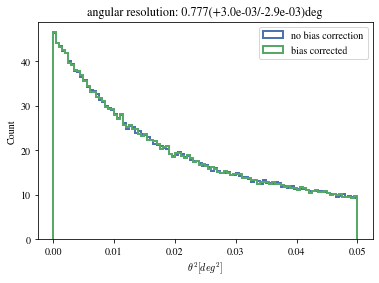

In [8]:
def plot_theta2(events, ax=None, bias_correction=True):
    ax = plt.gca() if ax is None else ax
    opt = dict(bins=100, range=(0, 0.05), density=True, histtype='step', bias_correction=False, lw=2)
    ax=ctaplot.plots.plot_theta2(events['mc_alt'].quantity,  
                                 events['reco_alt'].quantity, 
                                 events['mc_az'].quantity, 
                                 events['reco_az'].quantity,
                                 ax=ax, 
                                 label='no bias correction',
                                 **opt)
    
    if bias_correction:
        opt['bias_correction'] = True
        ax=ctaplot.plots.plot_theta2(events['mc_alt'].quantity,
                                     events['reco_alt'].quantity,
                                     events['mc_az'].quantity,
                                     events['reco_az'].quantity,
                                     ax=ax, label='bias corrected', **opt)
        ax.legend()
    return ax

plot_theta2(params, bias_correction=True);

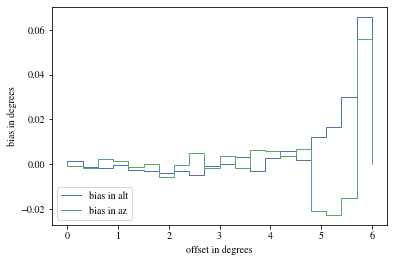

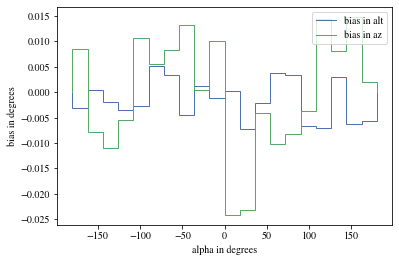

In [9]:
def plot_bias_per_offset(events, ax=None, **kwargs):
    offset, bias_alt = ctaplot.ana.bias_per_bin(events['mc_alt'], events['reco_alt'], events['offset'], bins=20)
    offset, bias_az = ctaplot.ana.bias_per_bin(events['mc_az'], events['reco_az'], events['offset'], bins=20)
    ax = plt.gca() if ax is None else ax
    ax.stairs(np.rad2deg(bias_alt), edges=np.rad2deg(offset), label='bias in alt', **kwargs)
    ax.stairs(np.rad2deg(bias_az), edges=np.rad2deg(offset), label='bias in az', **kwargs)
    ax.set_xlabel('offset in degrees')
    ax.set_ylabel('bias in degrees')
    ax.legend()
    return ax

def plot_bias_per_alpha(events, ax=None, **kwargs):
    alpha, bias_alt = ctaplot.ana.bias_per_bin(events['mc_alt'], events['reco_alt'], events['alpha'], bins=20)
    alpha, bias_az = ctaplot.ana.bias_per_bin(events['mc_az'], events['reco_az'], events['alpha'], bins=20)
    ax = plt.gca() if ax is None else ax
    ax.stairs(np.rad2deg(bias_alt), edges=np.rad2deg(alpha), label='bias in alt', **kwargs)
    ax.stairs(np.rad2deg(bias_az), edges=np.rad2deg(alpha), label='bias in az', **kwargs)
    ax.set_xlabel('alpha in degrees')
    ax.set_ylabel('bias in degrees')
    ax.legend()
    return ax

plot_bias_per_offset(params);
plt.show()
plot_bias_per_alpha(params);

In [10]:
# Select bright events to see the effect

bright_events = params[(params['intensity']>500)]
# selected_events = bright_events[(bright_events['src_x']>0) & (bright_events['src_y']>0)]
selected_events = bright_events[(-np.pi/4<bright_events['alpha'])&(bright_events['alpha']<np.pi/4.)]

In [11]:
def plot_all(events):
    fig, axes = plt.subplots(1, 5, figsize=(25,5))
    plot_true_pos(events, ax=axes[0])
    plot_psf(events, ax=axes[1])
    plot_theta2(events, ax=axes[2])
    plot_bias_per_offset(events, ax=axes[3])
    plot_bias_per_alpha(events, ax=axes[4])
    plt.tight_layout()
    plt.show()

Bright events


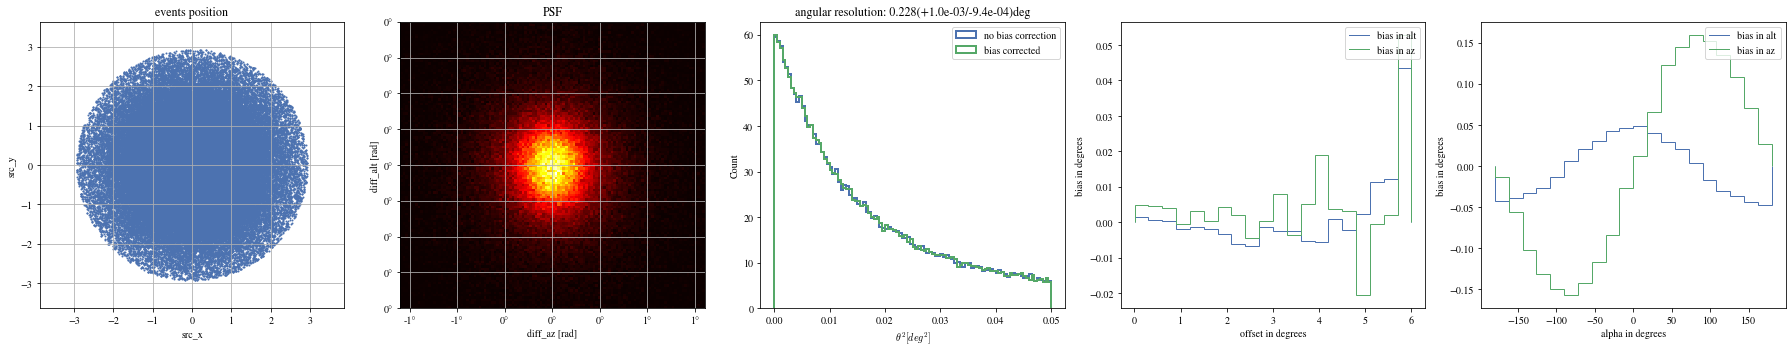

In [12]:
print("Bright events")
plot_all(bright_events)

###  Bright events in quarters

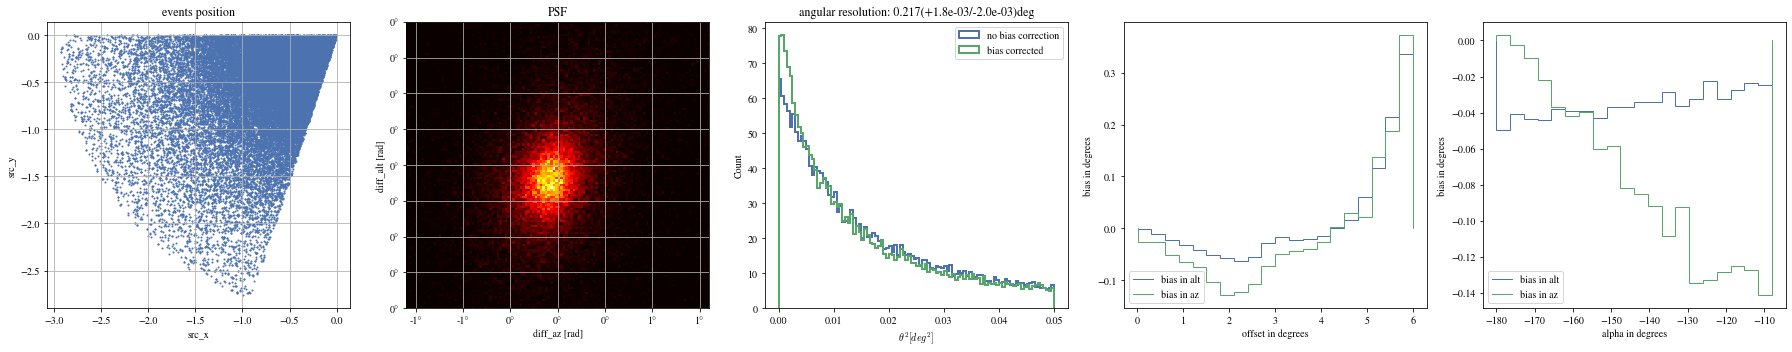

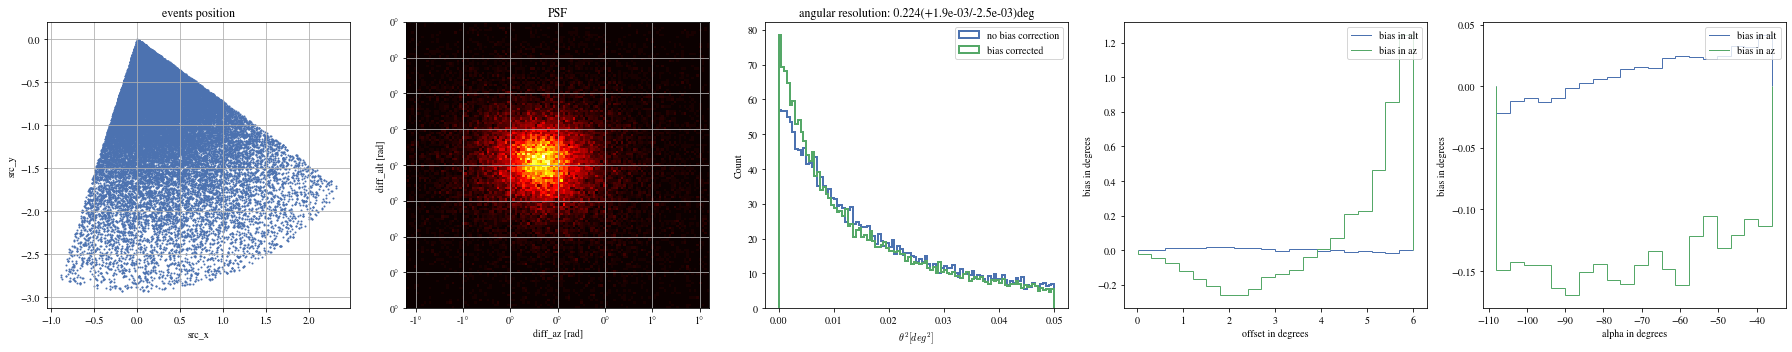

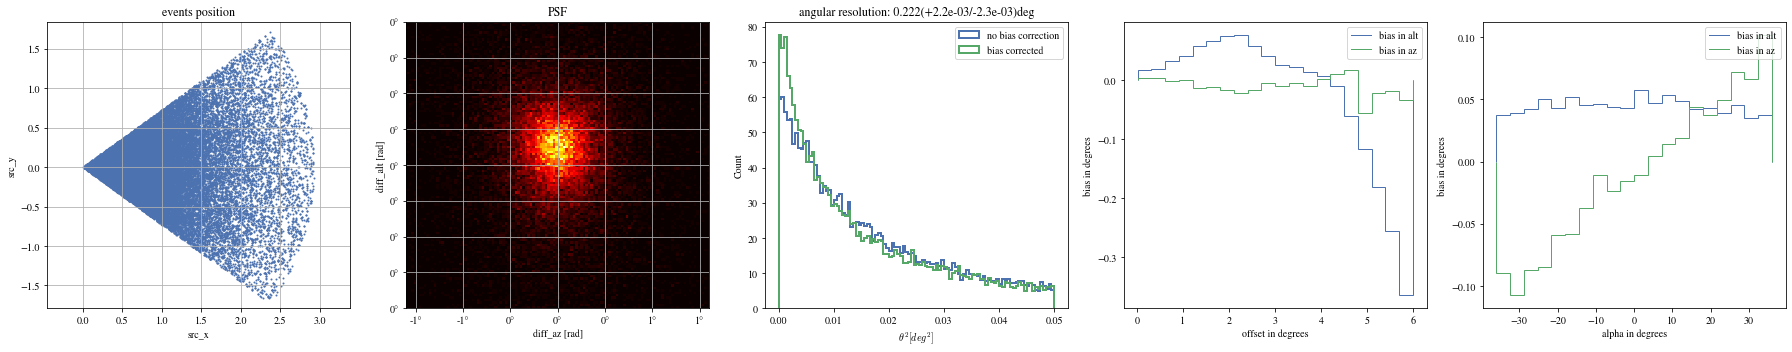

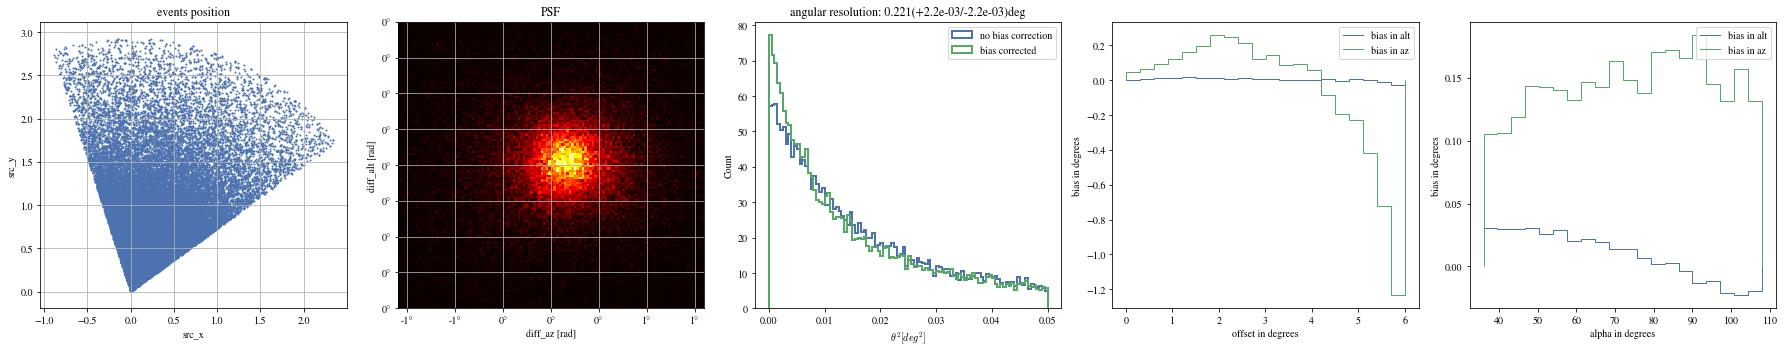

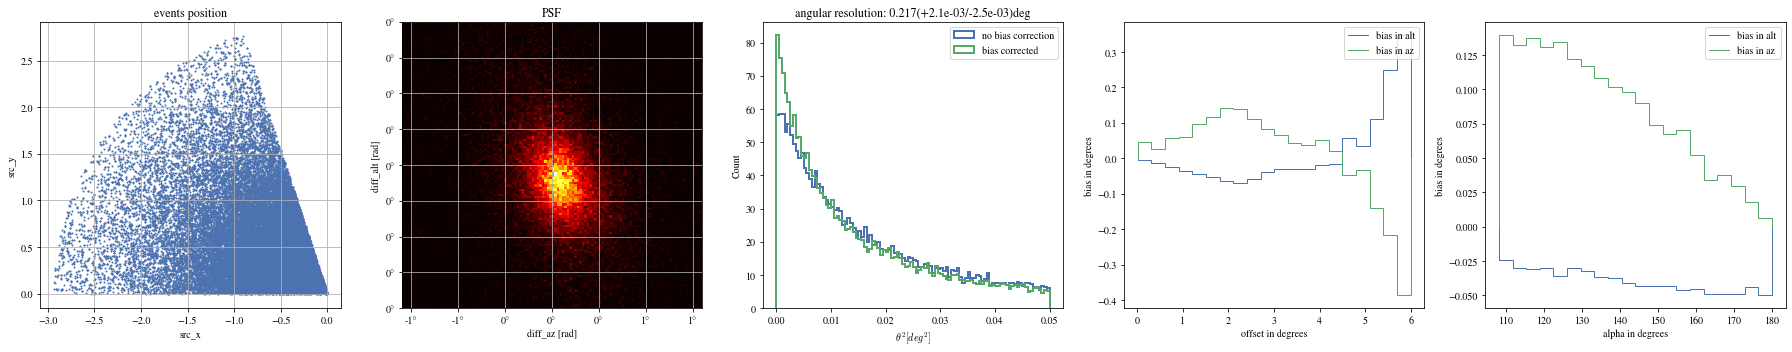

In [13]:
edges = np.histogram_bin_edges(bright_events['alpha'].value, bins=5)
for ii, low in enumerate(edges[:-1]):
    selected_events = bright_events[(low<bright_events['alpha'])&(bright_events['alpha']<edges[ii+1])]
    plot_all(selected_events)

## Correcting the bias

We can reconstruct the source position in the sky with a different focal length.
To visualize the bias, we can plot it as a function of alpha, the angle between the event position and the X-axis

In [14]:
from lstchain.reco.utils import reco_source_position_sky

In [15]:
def patch_events(events, true_focal_length=29.04*u.m, plot=True):
    
    raltaz = reco_source_position_sky(events['x'], events['y'],
                                  events['reco_disp_dx'], events['reco_disp_dy'],
                                  true_focal_length,
                                  events['alt_tel'], 
                                  events['az_tel'])
    
    events_corr = deepcopy(events)
    events_corr['reco_alt'] = raltaz.alt.to(u.rad)
    events_corr['reco_az'] = raltaz.az.to(u.rad)
    
    if plot:
        plt.figure(figsize=(10,6))
        opt = dict(bins=20)
        ctaplot.plots.plot_binned_bias(events['mc_alt'], 
                                   events['reco_alt'],
                                   events['alpha'],
                                   **opt,
                                   label='alt no corr'
                                  )

        ctaplot.plots.plot_binned_bias(events['mc_az'], 
                                       events['reco_az'],
                                       events['alpha'],
                                       **opt,
                                       label='az no corr'
                                      )

        x = np.linspace(-np.pi, np.pi, 100)
        plt.plot(x, np.cos(x)*0.0008, label='alt model')
        plt.plot(x, np.sin(x)*0.0028
                 , label='az model')

        ctaplot.plots.plot_binned_bias(events_corr['mc_alt'], 
                                   events_corr['reco_alt'],
                                   events_corr['alpha'],
                                   **opt,
                                   label='alt bias corrected',
                                  )

        ctaplot.plots.plot_binned_bias(events_corr['mc_az'], 
                                       events_corr['reco_az'],
                                       events_corr['alpha'],
                                       **opt,
                                       label='az bias corrected',
                                      )
        plt.xlabel('alpha [rad]')

        plt.legend()
        plt.show()
        plot_all(events_corr)
    
    return events_corr
    

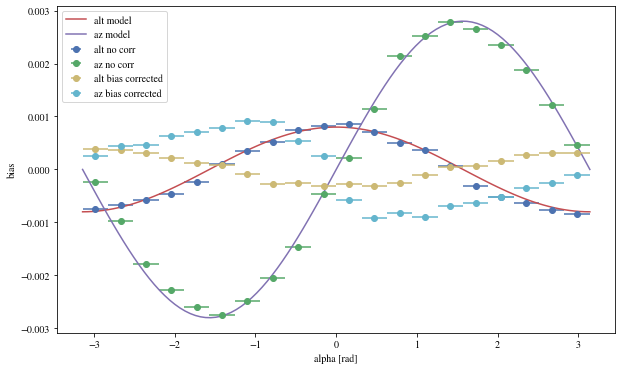

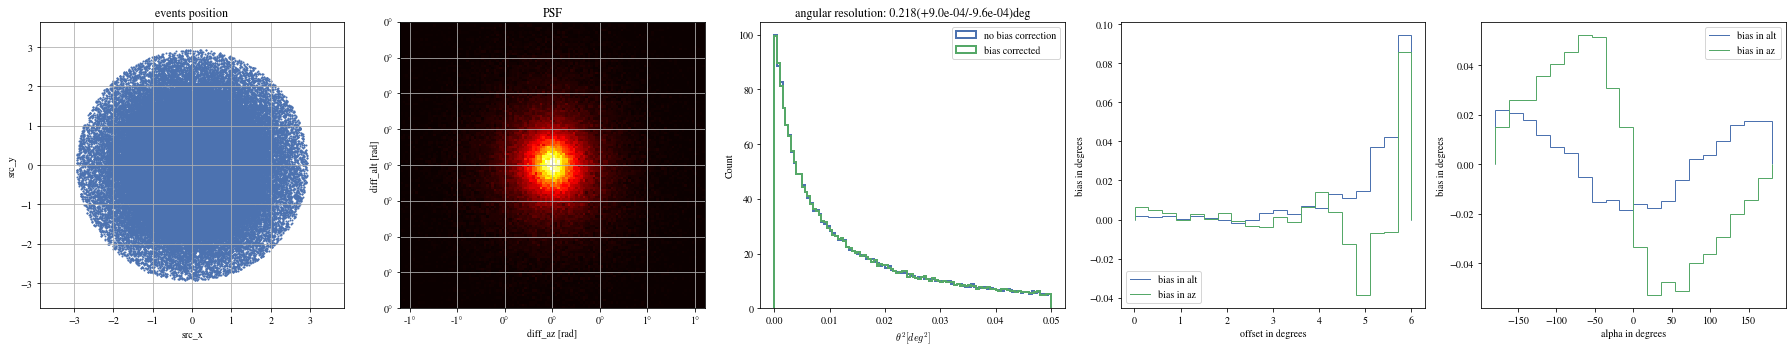

In [16]:
params_patched = patch_events(bright_events);

We can see that a bias is still present.    
Let's find the effective focal length that minimize the bias.

28.2 m


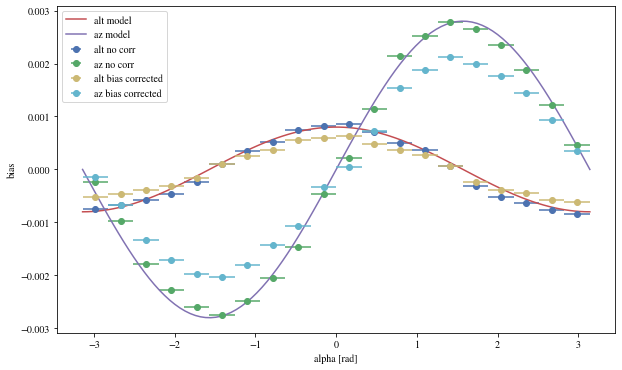

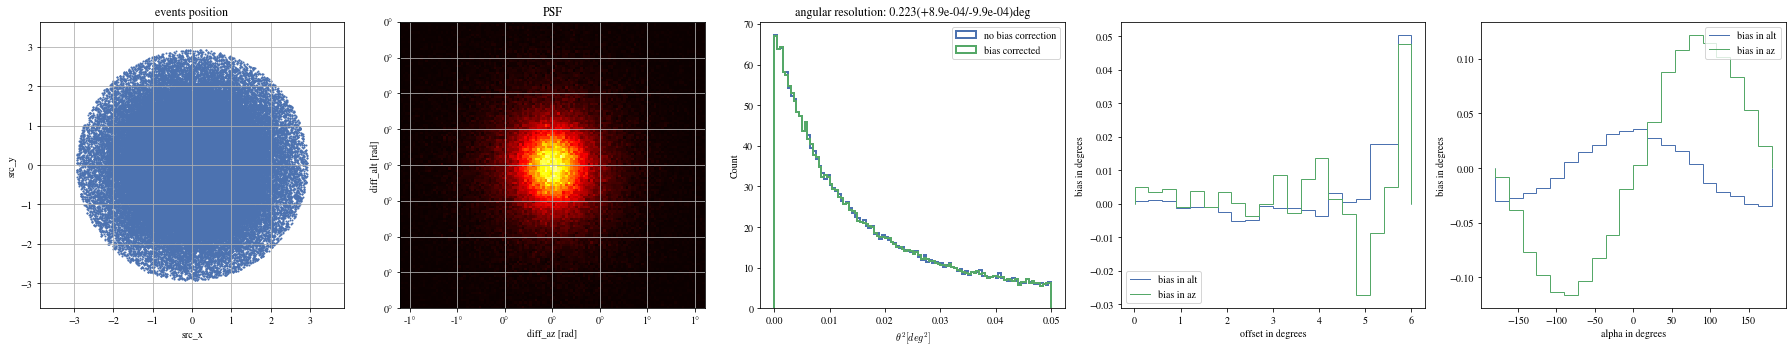

28.31111111111111 m


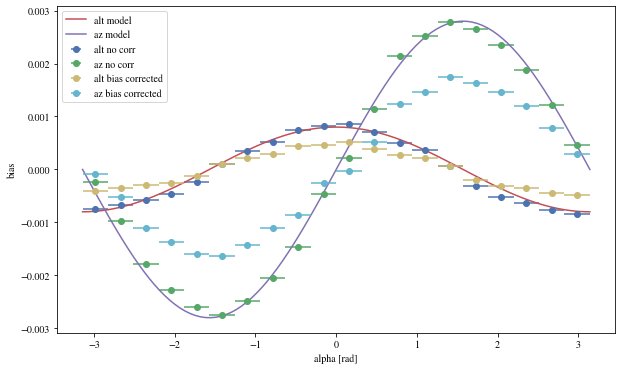

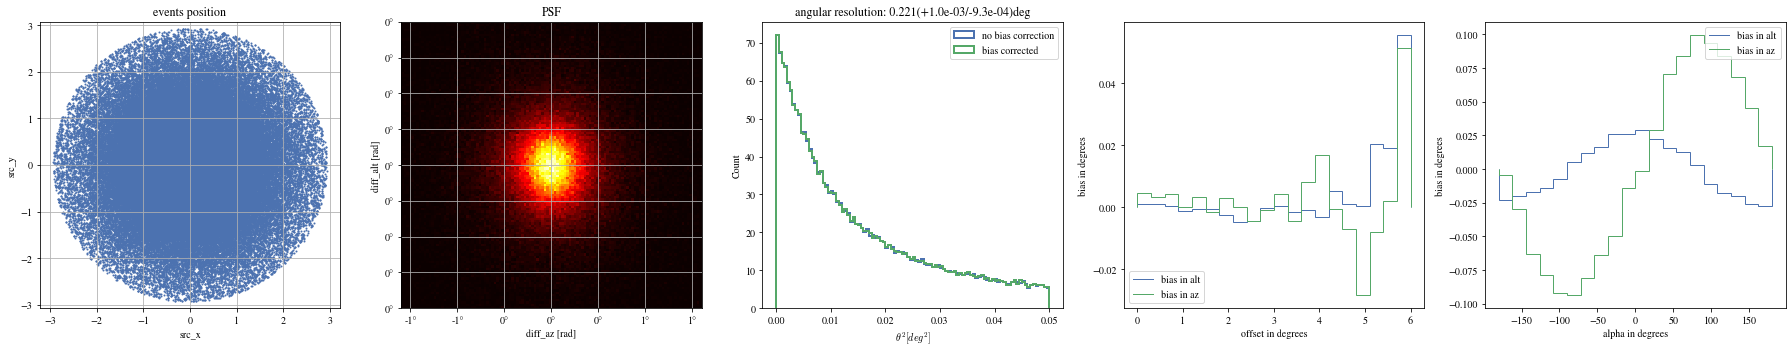

28.42222222222222 m


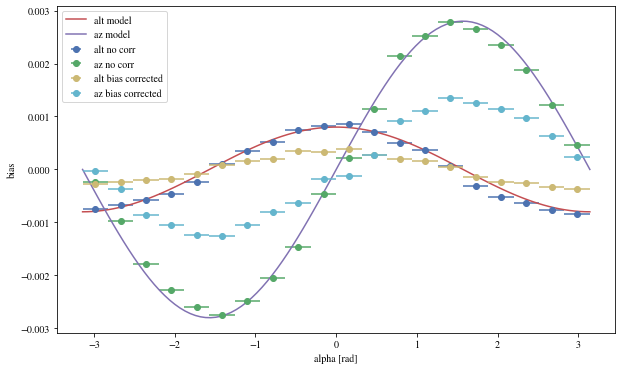

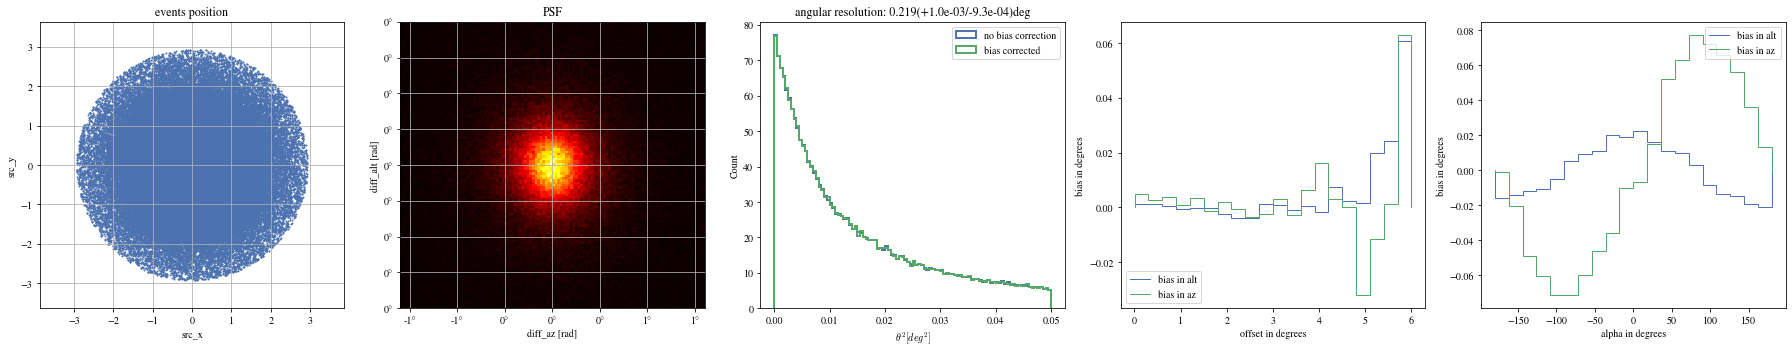

28.53333333333333 m


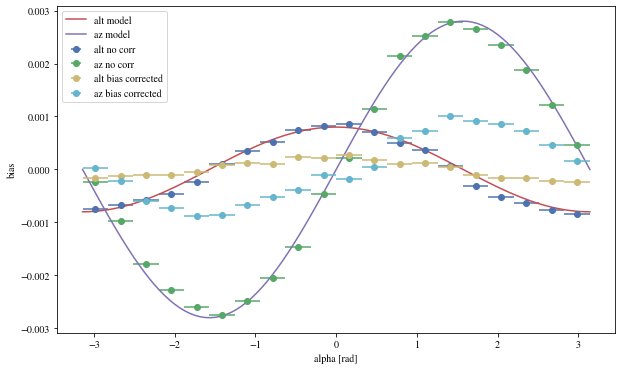

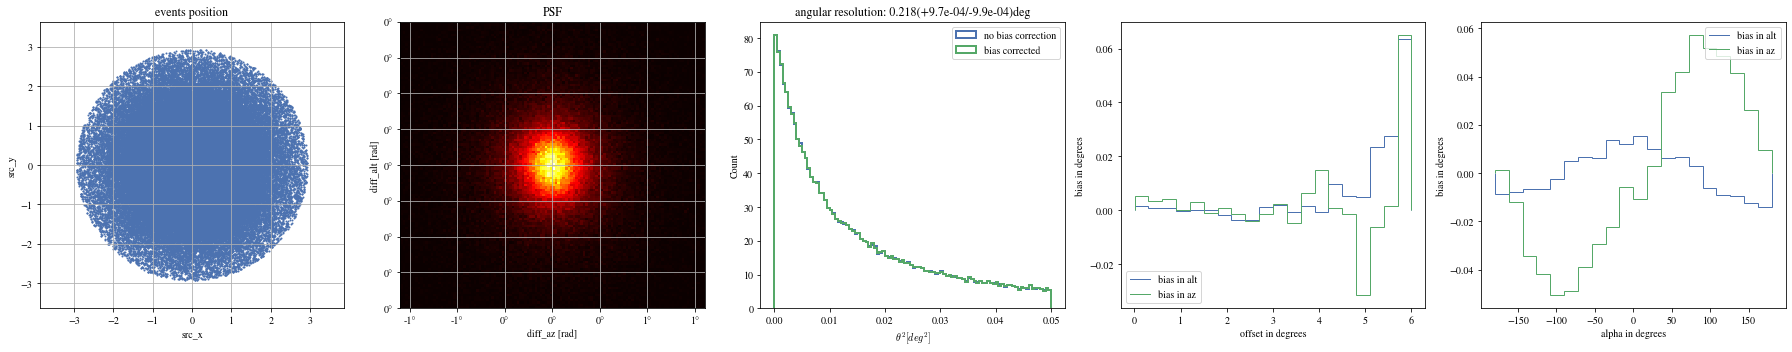

28.644444444444442 m


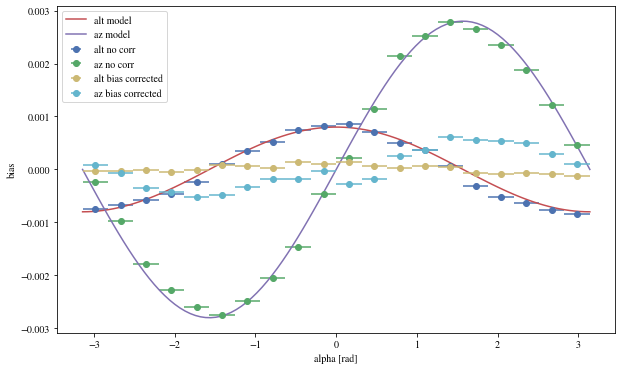

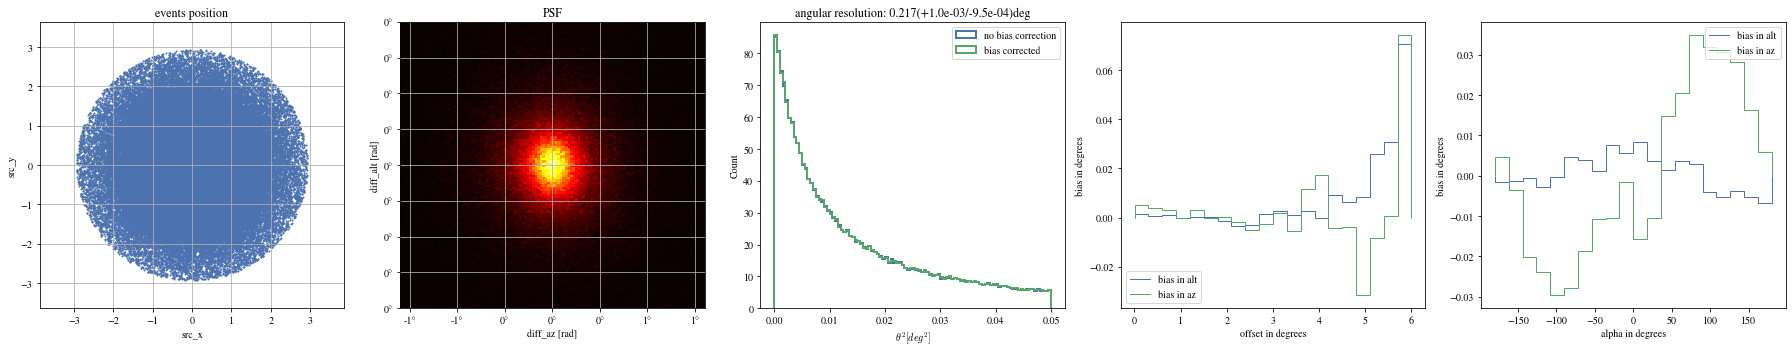

28.755555555555556 m


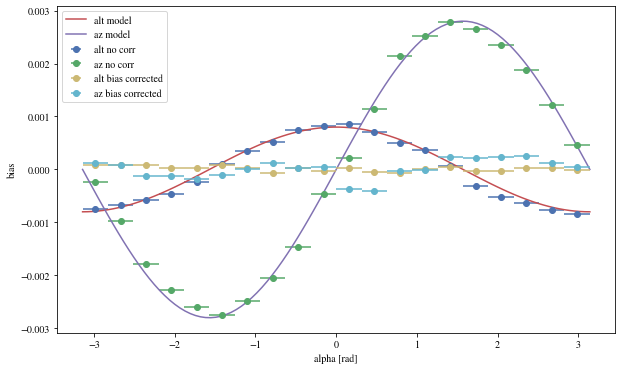

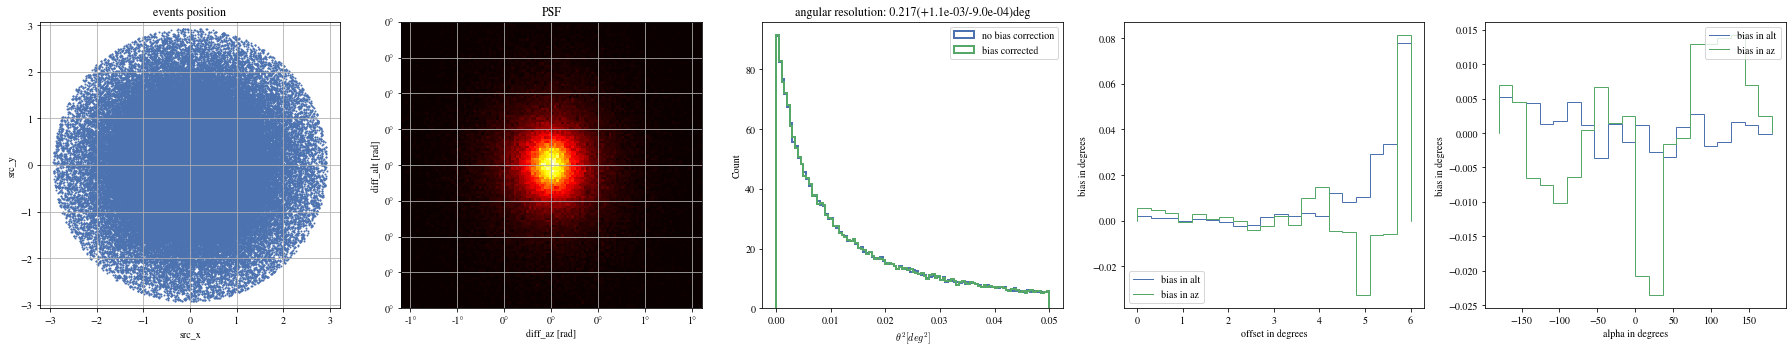

28.866666666666667 m


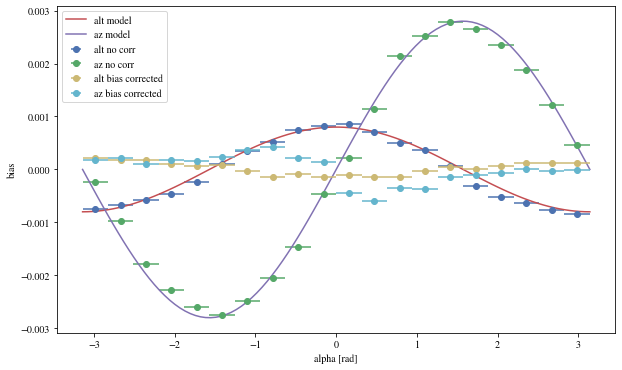

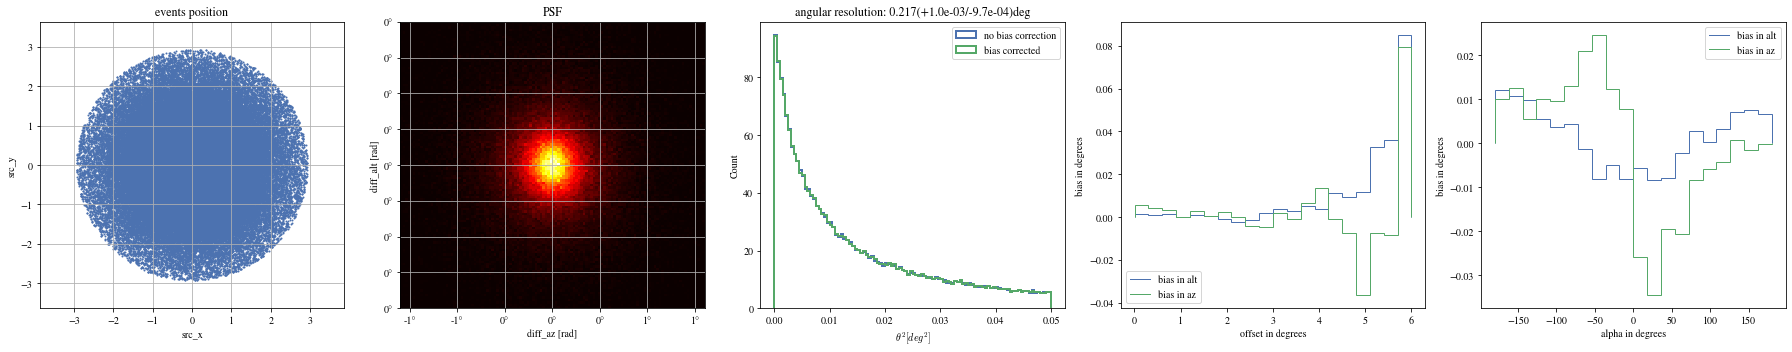

28.977777777777778 m


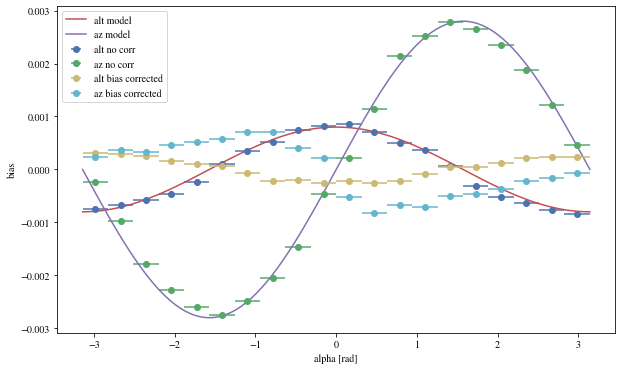

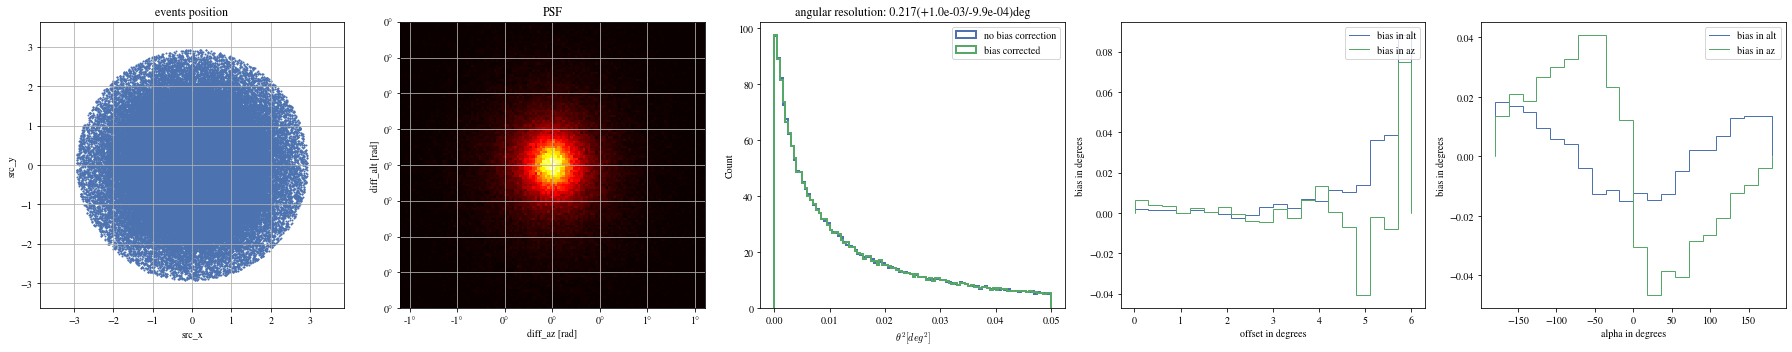

29.08888888888889 m


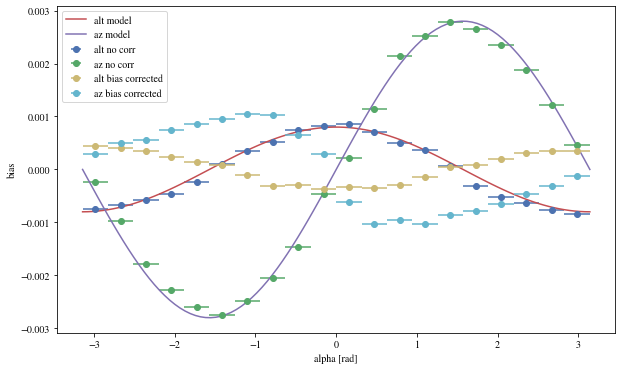

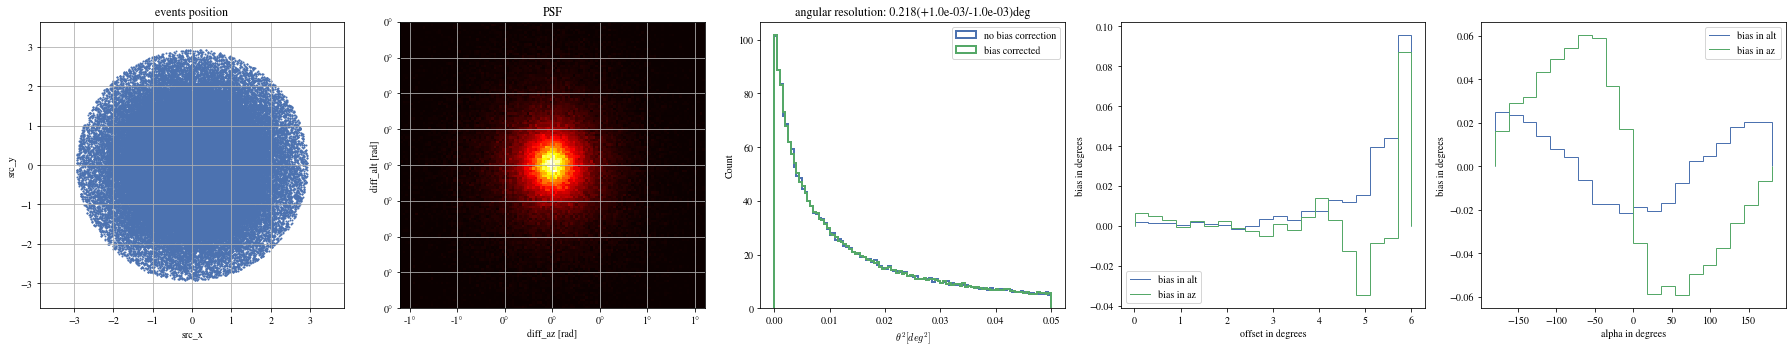

29.2 m


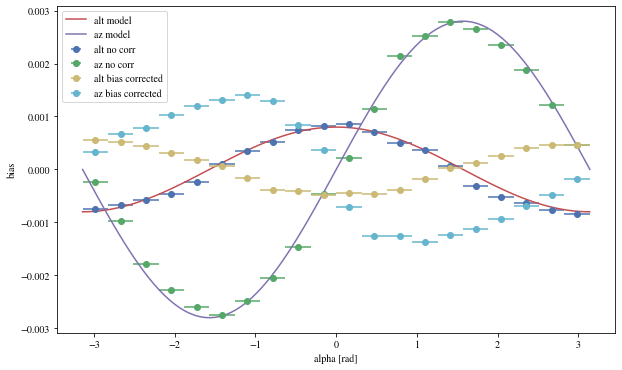

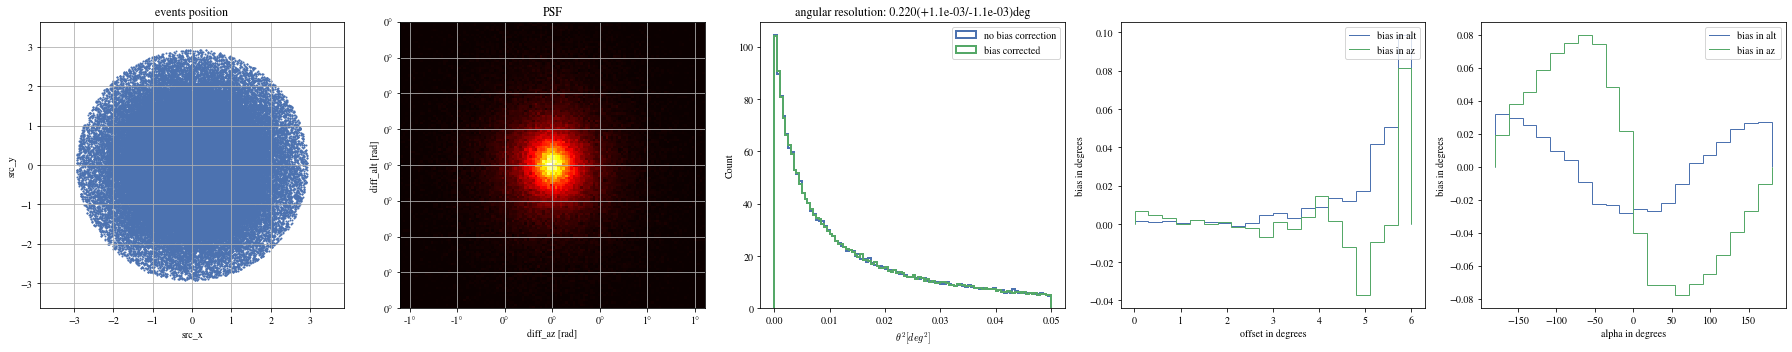

In [17]:
focal_lengths = np.linspace(28.2, 29.2, num=10) * u.m
bias_alt = []
bias_az = [] 
for fl in focal_lengths:
    print(fl)
    pe = patch_events(bright_events, true_focal_length=fl);
    _, bias = ctaplot.ana.bias_per_bin(pe['mc_alt'], pe['reco_alt'], pe['alpha'])
    bias_alt.append(np.rad2deg(np.mean(np.abs(bias))))
    _, bias = ctaplot.ana.bias_per_bin(pe['mc_az'], pe['reco_az'], pe['alpha'])
    bias_az.append(np.rad2deg(np.mean(np.abs(bias))))


We can find the effective focal length that minimize the bias:

The focal length that minimize the bias: 28.756 m


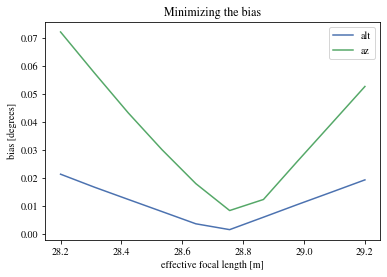

In [18]:
plt.plot(focal_lengths, bias_alt, label='alt')
plt.plot(focal_lengths, bias_az, label='az')
plt.title('Minimizing the bias')
plt.xlabel('effective focal length [m]')
plt.ylabel('bias [degrees]')
plt.legend()

assert np.argmin(bias_alt) == np.argmin(bias_az)
print(f"The focal length that minimize the bias: {focal_lengths[np.argmin(bias_alt)]:.3f}")

Let's see the results with that focal length:

In [19]:
params_patched = patch_events(bright_events, focal_lengths[np.argmin(bias_alt)], plot=False);
add_params(params_patched)

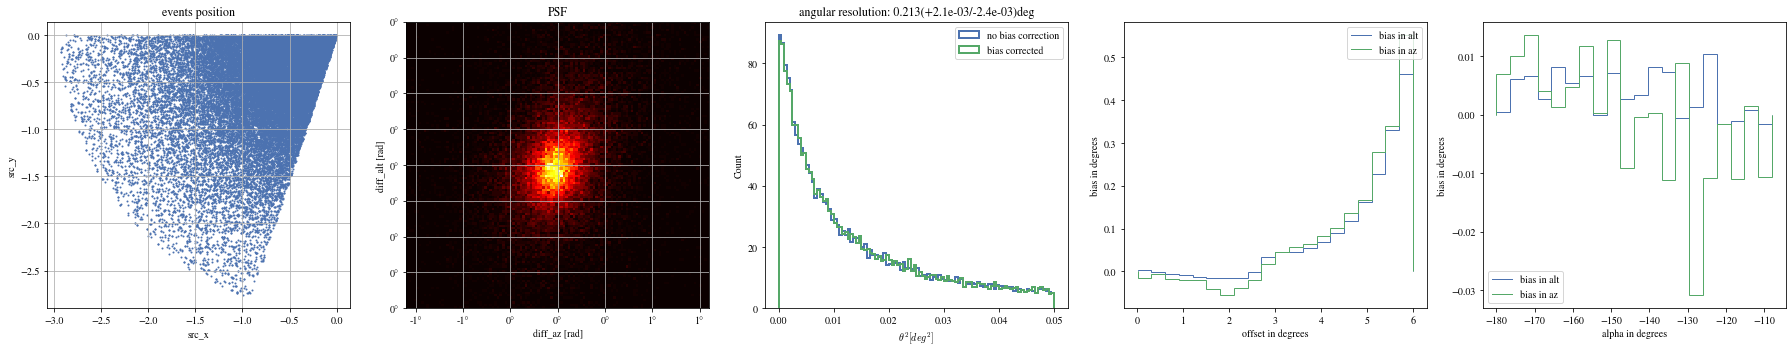

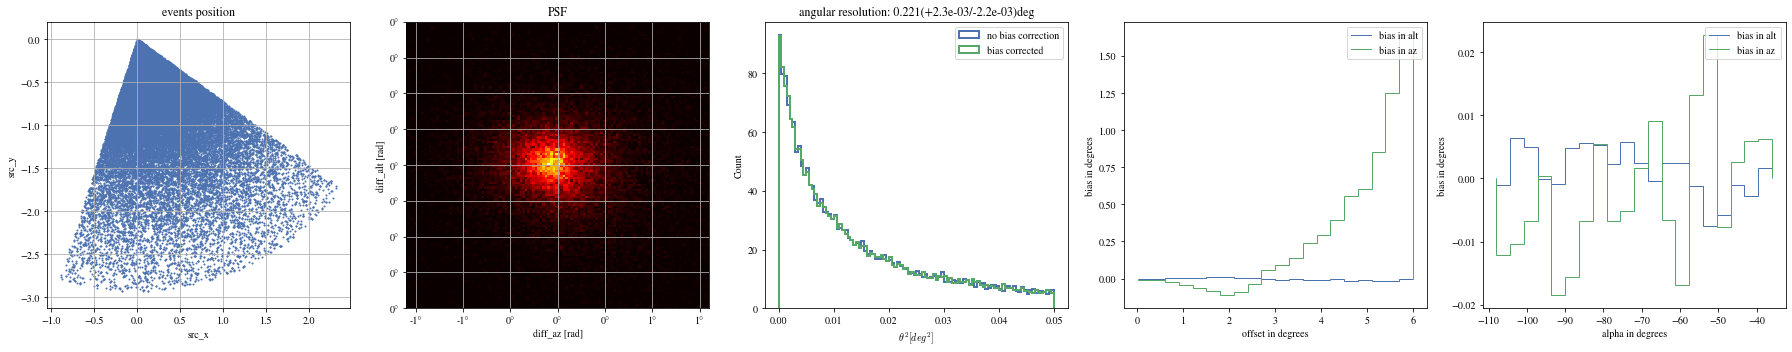

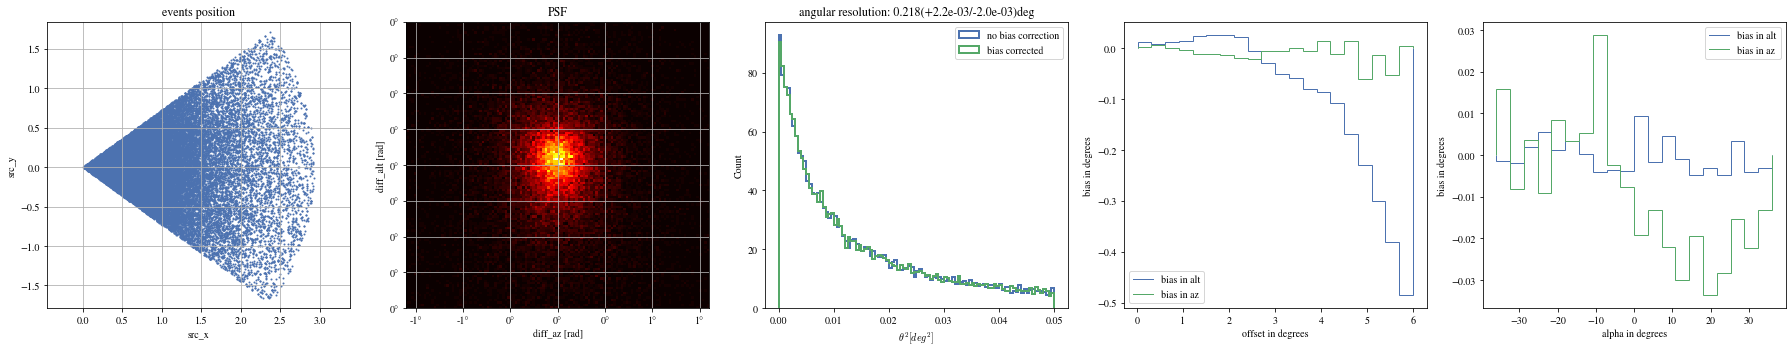

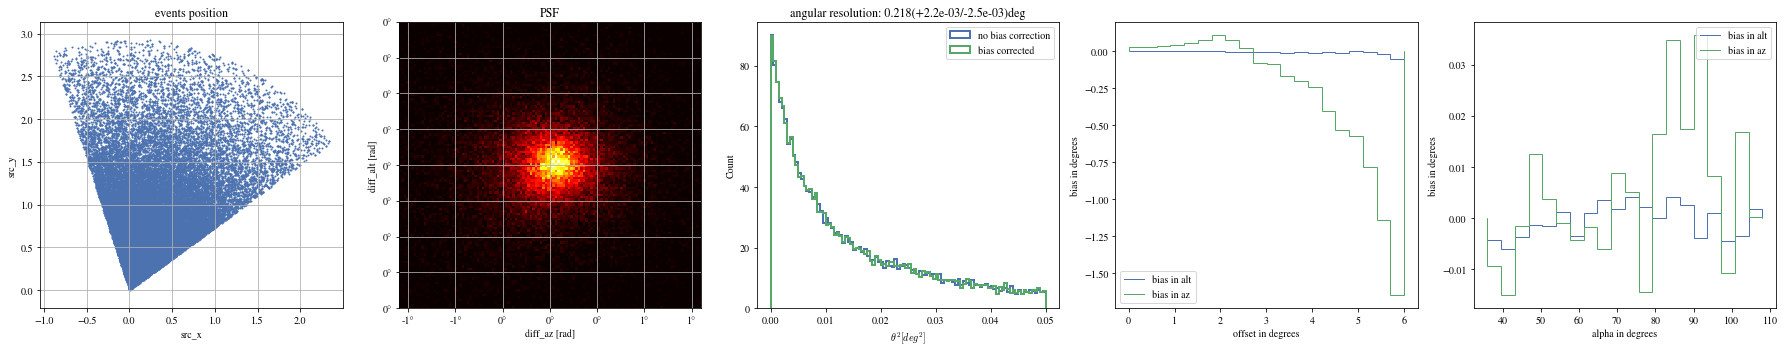

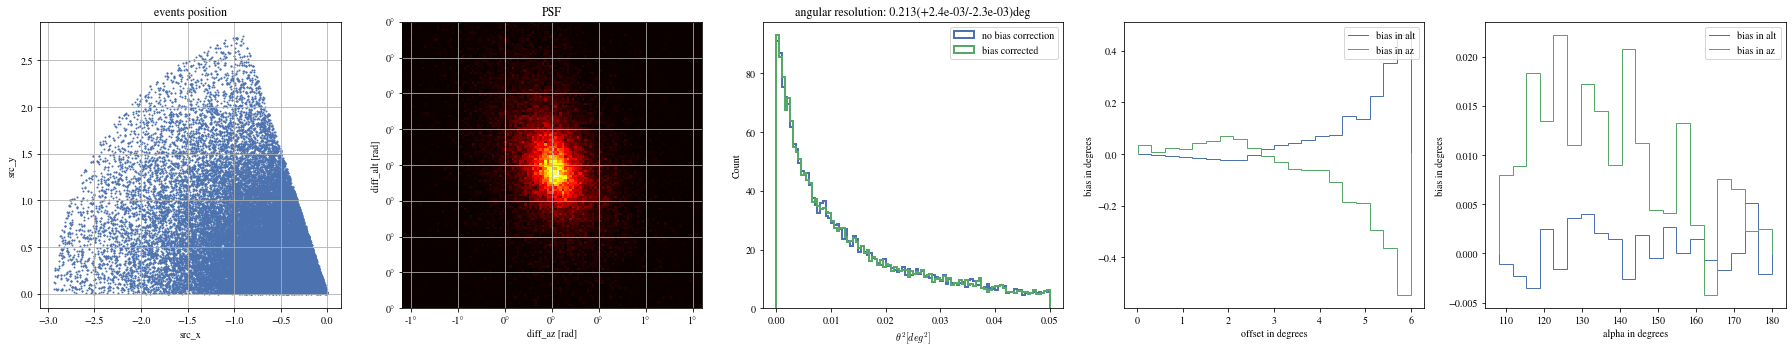

In [20]:
edges = np.histogram_bin_edges(params_patched['alpha'].value, bins=5)
for ii, low in enumerate(edges[:-1]):
    selected_events = params_patched[(low<bright_events['alpha'])&(params_patched['alpha']<edges[ii+1])]
    plot_all(selected_events)

The alpha-dependence is now gone

## Angular resolution before and after

In [21]:
selected_events = params[(params['intensity']>100) & (params['gammaness']>0.4)]
selected_corr = patch_events(selected_events, plot=False)

(0.0, 0.4)

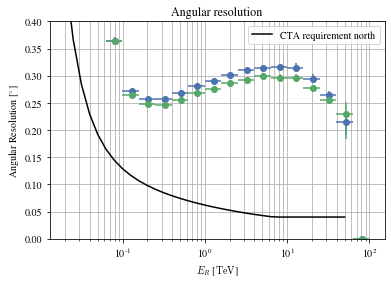

In [22]:
ctaplot.plot_angular_resolution_per_energy(selected_events['mc_alt'].quantity,
                                           selected_events['reco_alt'].quantity,
                                           selected_events['mc_az'].quantity,
                                           selected_events['reco_az'].quantity,
                                           selected_events['reco_energy'].quantity,)

ctaplot.plot_angular_resolution_per_energy(selected_corr['mc_alt'].quantity,
                                           selected_corr['reco_alt'].quantity,
                                           selected_corr['mc_az'].quantity,
                                           selected_corr['reco_az'].quantity,
                                           selected_corr['reco_energy'].quantity,)


ctaplot.plot_angular_resolution_cta_requirement('north', color='black')
plt.ylim(0, 0.4)

## Testing the same correction on point source gammas

In [23]:
filename = 'dl2_gamma_20deg_180deg_off0.4deg_20220215_v0.9.1_prod5_trans_80_local_tailcut_8_4_testing.h5'

def analyis(filename):
    params = read_table(filename, path=dl2_params_lstcam_key)
    add_params(params)
    # bright_events = params[(params['intensity']>5000)]
    bright_events = params[(params['intensity']>50) & ((params['gammaness']>0.7))]
    bright_events_corr = patch_events(bright_events, true_focal_length=29.04*u.m, plot=False)


    fig, axes = plt.subplots(1, 3, figsize=(20,5))
    
    plot_psf(bright_events_corr, ax=axes[0])

    opt=dict(bins=50,  histtype='step', range=(0, 0.1))
    ctaplot.plot_theta2(bright_events['mc_alt'].quantity,
                       bright_events['reco_alt'].quantity,
                       bright_events['mc_az'].quantity,
                       bright_events['reco_az'].quantity,
                        ax=axes[1],
                        label='no bias correction',
                        **opt
                       )
    
    ctaplot.plot_theta2(bright_events_corr['mc_alt'].quantity,
                   bright_events_corr['reco_alt'].quantity,
                   bright_events_corr['mc_az'].quantity,
                   bright_events_corr['reco_az'].quantity,
                        ax=axes[1],
                    label='bias corrected',
                        **opt
                   )
    axes[1].legend()
    
    ctaplot.plot_angular_resolution_per_energy(bright_events['mc_alt'].quantity,
                                           bright_events['reco_alt'].quantity,
                                           bright_events['mc_az'].quantity,
                                           bright_events['reco_az'].quantity,
                                           bright_events['reco_energy'].quantity,
                                                  ax=axes[-1],
                                             label='no bias correction',  
                                              )


    ctaplot.plot_angular_resolution_per_energy(bright_events_corr['mc_alt'].quantity,
                                               bright_events_corr['reco_alt'].quantity,
                                               bright_events_corr['mc_az'].quantity,
                                               bright_events_corr['reco_az'].quantity,
                                               bright_events_corr['reco_energy'].quantity,
                                               ax=axes[-1],
                                               label='bias corrected',
                                               # ls='--'
                                              )

    ctaplot.plot_angular_resolution_cta_requirement('north', color='black', ax=axes[-1])
    axes[-1].set_ylim(0, 0.4)

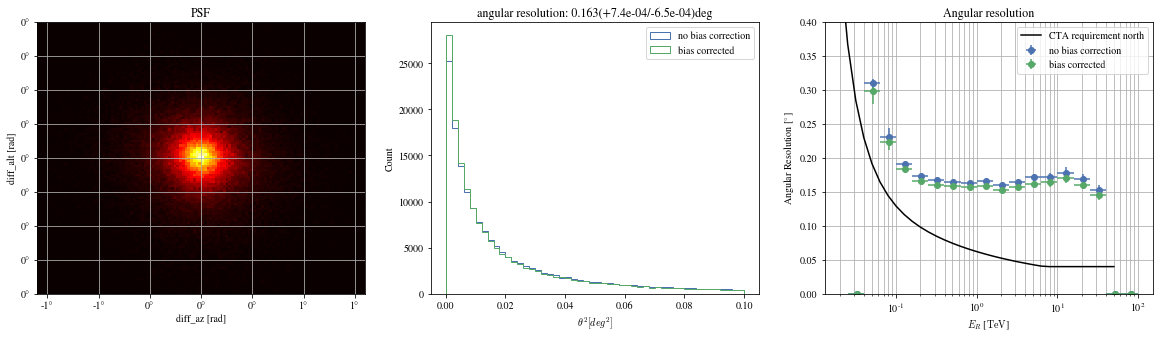

In [24]:
analyis(filename)